In [1]:
# libraries and dataset imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

daily_df = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv') # df containing all daily activity data for each user
weight_log = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv') # records of users weight logs
sleep_log = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv') # records of users sleep logs

# Introduction

*Insert intro text here* \
Talk about google cert, dataset, the case study, analysis phases etc.

# Preparing and Processing the Data

*Insert a brief description of the phases here and steps I am taking*

## Examining the Daily Activity Dataset

In [2]:
daily_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [3]:
daily_df.shape

(940, 15)

In [4]:
# checking the datatype of each column

daily_df.dtypes

Id                            int64
ActivityDate                 object
TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object

In [5]:
# Reformat dates the datetime

daily_df['ActivityDate'] = pd.to_datetime(daily_df['ActivityDate'])

daily_df.dtypes

Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
dtype: object

In [6]:
# Number of users, number of days and study period

users = daily_df['Id'].nunique()
days = daily_df['ActivityDate'].nunique()
min_date = daily_df['ActivityDate'].min().date()
max_date = daily_df['ActivityDate'].max().date()

print("There were", users, "users recorded for", days, "days from", min_date, "to", max_date)

There were 33 users recorded for 31 days from 2016-04-12 to 2016-05-12


In [7]:
# Frequency of records and checking for duplicates

every_day = daily_df['Id'].value_counts().loc[lambda x : x == 31].count() # count of Ids with 31 records (value_counts returns number of records per user, loc and lambda filter for desired number)
missed_days = daily_df['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with less than 31 records
min_records = daily_df['Id'].value_counts().min()
dup_count = daily_df.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers who missed some days:', missed_days, '\nMinimum number of records:', daily_df['Id'].value_counts().min(), '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 21 
Users who missed some days: 12 
Minimum number of records: 4 
Duplicate records: 0


In [8]:
# Looking for null values

for col in daily_df.columns.values:
    if (daily_df.loc[daily_df[col].isnull() == True]).empty: # if there are no nulls in the current column it will go to the next column
        pass
    else:
        print(col, ':', daily_df[col].isnull().sum(), 'Nulls') # prints column name and count of nulls

There are no null values in the dataset.

### Deciphering the Relationship Between Distance Fields 
I wanted to confirm that logged activities distance and tracker distance added up to total distance but quickly found that that was not the case

In [9]:
# Count of records where total distance is not equal to tracker distance + logged activities distance

print("Records where total distance not equal to tracker distance + logged activities distance:",daily_df['LoggedActivitiesDistance'].loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'] + daily_df['LoggedActivitiesDistance'])].count())

# Count of activity distances greater than 0

print("Records where logged activities distance greater than zero:",daily_df['LoggedActivitiesDistance'].loc[daily_df['LoggedActivitiesDistance'] > 0].count())

Records where total distance not equal to tracker distance + logged activities distance: 32
Records where logged activities distance greater than zero: 32


In [10]:
# Check if the two subsets overlap

daily_df.loc[daily_df['LoggedActivitiesDistance'] > 0].equals(daily_df.loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'] + daily_df['LoggedActivitiesDistance'])])

True

All records with a logged activities distances greater than zero coincide with records where total distance isn't the sum of tracker distance and logged activities distance.

In [11]:
# Records where total distance is not equal to tracker distance

print("Record count:",daily_df['LoggedActivitiesDistance'].loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'])].count())
daily_df.loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'])]

Record count: 15


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
689,6962181067,2016-04-21,11835,9.71,7.88,4.081692,3.99,2.10,3.51,0.11,53,27,214,708,2179
693,6962181067,2016-04-25,13239,9.27,9.08,2.785175,3.02,1.68,4.46,0.10,35,31,282,637,2194
707,6962181067,2016-05-09,12342,8.72,8.68,3.167822,3.90,1.18,3.65,0.00,43,21,231,607,2105
711,7007744171,2016-04-12,14172,10.29,9.48,4.869783,4.50,0.38,5.41,0.00,53,8,355,1024,2937
712,7007744171,2016-04-13,12862,9.65,8.60,4.851307,4.61,0.56,4.48,0.00,56,22,261,1101,2742
713,7007744171,2016-04-14,11179,8.24,7.48,3.285415,2.95,0.34,4.96,0.00,34,6,304,1096,2668
717,7007744171,2016-04-18,14816,10.98,9.91,4.930550,3.79,2.12,5.05,0.02,48,31,284,1077,2832
718,7007744171,2016-04-19,14194,10.48,9.50,4.942142,4.41,0.76,5.31,0.00,53,17,304,1066,2812
719,7007744171,2016-04-20,15566,11.31,10.41,4.924841,4.79,0.67,5.86,0.00,60,33,347,1000,3096
724,7007744171,2016-04-25,18229,13.34,12.20,4.861792,4.31,1.37,7.67,0.00,51,24,379,986,3055


In [12]:
# Records where total distance is equal to tracker distance
# We can see that the logged activities distance is equal to 0

daily_df.loc[daily_df['TotalDistance'] == (daily_df['TrackerDistance'])]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-04-12,13162,8.500000,8.500000,0.0,1.88,0.55,6.06,0.00,25,13,328,728,1985
1,1503960366,2016-04-13,10735,6.970000,6.970000,0.0,1.57,0.69,4.71,0.00,21,19,217,776,1797
2,1503960366,2016-04-14,10460,6.740000,6.740000,0.0,2.44,0.40,3.91,0.00,30,11,181,1218,1776
3,1503960366,2016-04-15,9762,6.280000,6.280000,0.0,2.14,1.26,2.83,0.00,29,34,209,726,1745
4,1503960366,2016-04-16,12669,8.160000,8.160000,0.0,2.71,0.41,5.04,0.00,36,10,221,773,1863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,2016-05-08,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847
936,8877689391,2016-05-09,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710
937,8877689391,2016-05-10,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832
938,8877689391,2016-05-11,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832


Clearly the total distance is not calculated by adding the two together, without knowing how Fitbit handles this data, I cannot decipher the relationship. <br>
Because of this, I will only use the total distance moving forward.

### Looking for Outliers

<Axes: >

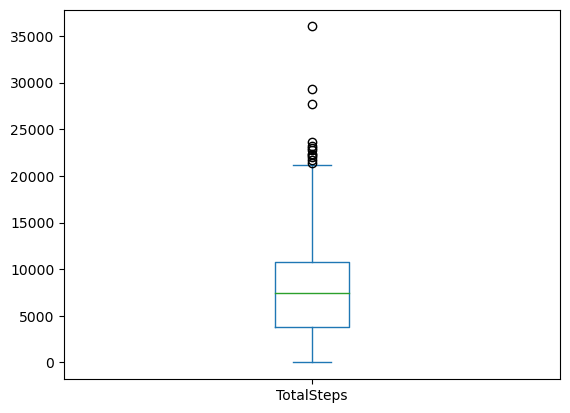

In [13]:
# Total steps boxplot

daily_df.plot(y = 'TotalSteps', kind = 'box')

In [14]:
daily_df.loc[daily_df['TotalSteps'] == daily_df['TotalSteps'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
50,1624580081,2016-05-01,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,186,63,171,1020,2690


In [15]:
daily_df.loc[daily_df['TotalDistance'] == daily_df['TotalDistance'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
50,1624580081,2016-05-01,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,186,63,171,1020,2690


The record with the most total steps is also the record with the highest total distance. This indicates to me that the record is accurate and should be kept. While it is a lot of steps, it is not completely outrageous either.

<Axes: >

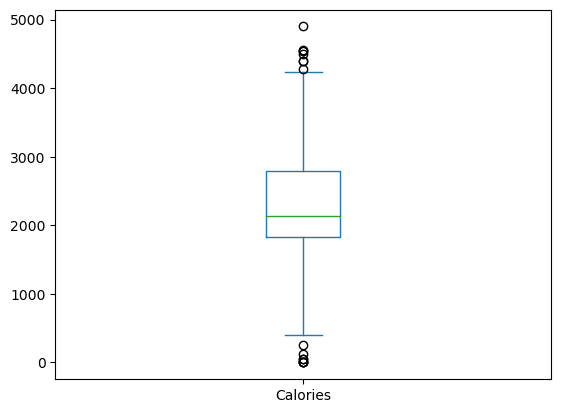

In [16]:
# Calories boxplot

daily_df.plot(y = 'Calories', kind = 'box')

In [17]:
daily_df.loc[daily_df['Calories'] == daily_df['Calories'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
606,6117666160,2016-04-21,19542,15.01,15.01,0.0,0.98,0.4,5.62,0.0,11,19,294,579,4900


The record with the most calories burnt, while very high, is well within the range of normal. 

In [18]:
daily_df.loc[daily_df['Calories'] == daily_df['Calories'].min()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
30,1503960366,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
653,6290855005,2016-05-10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
817,8253242879,2016-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
879,8583815059,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0


Clearly, these are times when the device was not worn for the whole day. No concerning minimums ie. negatives.

In [19]:
# Looking for any active minute records with values greater than 24 hours (impossible)

minute_cols = ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']

for i in minute_cols:
    if daily_df.loc[daily_df[i] > 1440].empty: # if the current column does not have any records higher than 1440 min it moves to the next one
        pass
    else:
        print(i, ':', (daily_df[i] > 1440).sum(), 'active minute records greater than 24hrs') # prints the column name and a count of records higher than 1440 min

In [20]:
# Looking for any active distance records greater than total distance

dist_cols = ['VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance']

for i in dist_cols:
    if daily_df.loc[daily_df[i] > daily_df['TotalDistance']].empty: # if the current column does not have any records where the value is higher than the total distance it moves to the next one
        pass
    else:
        print(i, ':', (daily_df[i] > daily_df['TotalDistance']).sum(), 'active distance records greater than total distance') # prints the column name and count of records higher than the total distance

## Examining the Sleep Log Dataset

In [21]:
sleep_log.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [22]:
sleep_log.shape

(413, 5)

In [23]:
sleep_log.dtypes

Id                     int64
SleepDay              object
TotalSleepRecords      int64
TotalMinutesAsleep     int64
TotalTimeInBed         int64
dtype: object

In [24]:
# Reformat dates to datetime

sleep_log['SleepDay'] = pd.to_datetime(sleep_log['SleepDay'])

sleep_log.dtypes

Id                             int64
SleepDay              datetime64[ns]
TotalSleepRecords              int64
TotalMinutesAsleep             int64
TotalTimeInBed                 int64
dtype: object

In [25]:
# Record frequency and checking for duplicate records

every_day = sleep_log['Id'].value_counts().loc[lambda x : x >= 31].count() # count of Ids with 31 records (or more because one of the users with duplicate records has 32 records)
missed_days = sleep_log['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with less than 31 records
sleep_users = every_day + missed_days
dup_count = sleep_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nUsers who did not record their sleep at all:', users - sleep_users, '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 3 
Users with records for some of the days: 21 
Users who did not record their sleep at all: 9 
Duplicate records: 3


There are 3 duplicate records. I will look at them and remove them.

In [26]:
sleep_log.loc[sleep_log.duplicated() == True]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
161,4388161847,2016-05-05,1,471,495
223,4702921684,2016-05-07,1,520,543
380,8378563200,2016-04-25,1,388,402


In [27]:
sleep_log = sleep_log.drop_duplicates()

# run the frequency/duplicate check again 

every_day = sleep_log['Id'].value_counts().loc[lambda x : x == 31].count()
missed_days = sleep_log['Id'].value_counts().loc[lambda x : x < 31].count()
dup_count = sleep_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nUsers who did not record their sleep at all:', users - (every_day + missed_days), '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 3 
Users with records for some of the days: 21 
Users who did not record their sleep at all: 9 
Duplicate records: 0


In [28]:
# Looking for null values

for col in sleep_log.columns.values:
    if (sleep_log.loc[sleep_log[col].isnull() == True]).empty:
        pass
    else:
        print(col, ':', sleep_log[col].isnull().sum(), 'Nulls')

There are no null values in the dataset.

### Looking for Outliers

<Axes: >

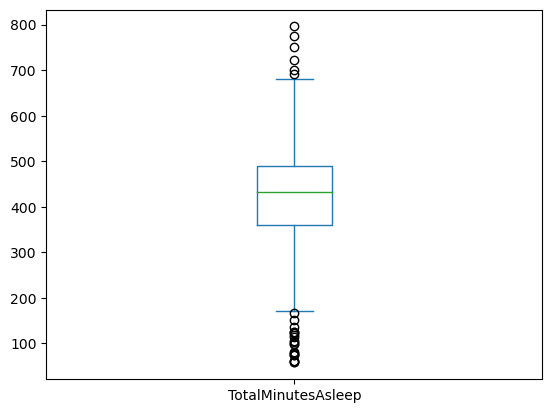

In [29]:
sleep_log.plot(y = 'TotalMinutesAsleep', kind = 'box')

In [30]:
sleep_log.loc[sleep_log['TotalMinutesAsleep'] == sleep_log['TotalMinutesAsleep'].max()]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
27,1644430081,2016-05-02,1,796,961


Most time spent asleep is 13 hours, quite high but not outside the possible range.

In [31]:
sleep_log.loc[sleep_log['TotalMinutesAsleep'] == sleep_log['TotalMinutesAsleep'].min()]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
338,7007744171,2016-05-01,1,58,61


Least amount of time spent asleep is just under an hour. Extremely low but there are many factors as to why it might be so low. For example, their watch could have died or they recorded a nap and not their overnight sleep.

In [32]:
# Looking for records where total time in bed is less than total minutes asleep (should not be possible)

sleep_log.loc[sleep_log['TotalMinutesAsleep'] > sleep_log['TotalTimeInBed']]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed


## Examining the Weight Log Dataset

In [33]:
weight_log.head()

,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,True,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,True,1463097599000


In [34]:
weight_log.shape

(67, 8)

In [35]:
weight_log.dtypes

Id                  int64
Date               object
WeightKg          float64
WeightPounds      float64
Fat               float64
BMI               float64
IsManualReport       bool
LogId               int64
dtype: object

In [36]:
# The date field also has time, if there are multiple time stamps on one date there will be duplicated dates
# Count of unique dates

weight_log['Date'].nunique()

56

In [37]:
# Reformat dates as datetime and remove the time portion

weight_log['Date'] = pd.to_datetime(weight_log['Date']).dt.date

weight_log.dtypes

Id                  int64
Date               object
WeightKg          float64
WeightPounds      float64
Fat               float64
BMI               float64
IsManualReport       bool
LogId               int64
dtype: object

In [38]:
# Count of unique dates after removing the timestamp
# The study period was 31 days, this lines up 

weight_log['Date'].nunique()

31

In [39]:
# Record frequency and checking for duplicates

every_day = weight_log['Id'].value_counts().loc[lambda x : x == 31].count() # count of Ids with 31 records
missed_days = weight_log['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with 31 records
max_records = weight_log['Id'].value_counts().max()
weight_users = every_day + missed_days
dup_count = weight_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nHighest number of records:', max_records, '\nUsers who did not record their weight at all:', users - weight_users, '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 0 
Users with records for some of the days: 8 
Highest number of records: 30 
Users who did not record their weight at all: 25 
Duplicate records: 0


In [40]:
# Looking for null values

for col in weight_log.columns.values:
    if (weight_log.loc[weight_log[col].isnull() == True]).empty:
        pass
    else:
        print(col, ':', weight_log[col].isnull().sum(), 'Nulls')

Fat : 65 Nulls


65 out of 67 records are null for this column. I will remove the Fat column.

In [41]:
# Removing the Fat column

weight_log = weight_log.drop('Fat', axis=1)

weight_log.head()

,Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
0,1503960366,2016-05-02,52.599998,115.963147,22.650000,True,1462233599000
1,1503960366,2016-05-03,52.599998,115.963147,22.650000,True,1462319999000
2,1927972279,2016-04-13,133.500000,294.317120,47.540001,False,1460509732000
3,2873212765,2016-04-21,56.700001,125.002104,21.450001,True,1461283199000
4,2873212765,2016-05-12,57.299999,126.324875,21.690001,True,1463097599000


Wanted to check conversion between Kg to Lb but the conversion requires too many decimals to be accurate. Unable to properly compare.

# Analysis

*Insert brief description here*

## Daily Activity Analysis

Compare active min levels across users

In [42]:
daily_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [43]:
# Average total steps and calories per user

avg_steps_cals = daily_df[['Id', 'TotalSteps', 'Calories']]

avg_steps_cals = avg_steps_cals.groupby('Id').mean()

avg_steps_cals

,TotalSteps,Calories
Id,,
1503960366,12116.741935,1816.419355
1624580081,5743.903226,1483.354839
1644430081,7282.966667,2811.300000
1844505072,2580.064516,1573.483871
1927972279,916.129032,2172.806452
2022484408,11370.645161,2509.967742
2026352035,5566.870968,1540.645161
2320127002,4716.870968,1724.161290
2347167796,9519.666667,2043.444444


In [44]:
# Get an average of each level of active minutes and calculate a new field called exercise minutes, which is the sum of average very active minutes and fairly active minutes

active_min = daily_df[['Id', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']]

avg_active_min = active_min.groupby('Id').mean()

avg_active_min['exercise_min'] = avg_active_min['VeryActiveMinutes'] + avg_active_min['FairlyActiveMinutes']

In [45]:
# User counts for 4 exercise minute bins and calculate percent of total users

daily_exercise_min = pd.DataFrame(data=(avg_active_min['exercise_min'].value_counts(bins=4, sort=False)))

daily_exercise_min.rename(columns={'exercise_min': 'User_Count'}, inplace=True)

daily_exercise_min['%_of_Total_Users'] = ((daily_exercise_min['User_Count']/daily_exercise_min['User_Count'].sum()) * 100).round()

daily_exercise_min

,User_Count,%_of_Total_Users
"(0.237, 29.558]",16,48.0
"(29.558, 58.761]",11,33.0
"(58.761, 87.964]",4,12.0
"(87.964, 117.167]",2,6.0


Distance

In [46]:
# Find the percent breakdown of total distance into each level of active distance and look at the average per user

active_dist = daily_df.loc[:,('Id', 'TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance')]

distances = ['VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance']

for i in distances:
    new_col_name = "%_" + i
    active_dist[new_col_name] = ((active_dist[i]/active_dist['TotalDistance']) * 100).round()
    
avg_active_dist = active_dist[['Id','%_VeryActiveDistance', '%_ModeratelyActiveDistance', '%_LightActiveDistance', '%_SedentaryActiveDistance']].groupby('Id').mean()

avg_active_dist

,%_VeryActiveDistance,%_ModeratelyActiveDistance,%_LightActiveDistance,%_SedentaryActiveDistance
Id,,,,
1503960366,36.266667,10.233333,53.366667,0.000000
1624580081,7.064516,5.483871,87.000000,0.193548
1644430081,11.000000,13.033333,75.766667,0.133333
1844505072,0.350000,2.500000,97.150000,0.000000
1927972279,10.705882,3.352941,85.882353,0.000000
2022484408,28.580645,8.451613,63.032258,0.000000
2026352035,0.225806,0.419355,99.322581,0.000000
2320127002,2.387097,2.645161,94.967742,0.000000
2347167796,12.333333,14.277778,73.444444,0.000000


Compare steps

In [47]:
# Create a new column for steps per calories (Not clear on the usefulness of this. Might delete)

daily_df['step/cal'] = daily_df['TotalSteps'] / daily_df['Calories']
daily_df

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,step/cal
0,1503960366,2016-04-12,13162,8.500000,8.500000,0.0,1.88,0.55,6.06,0.00,25,13,328,728,1985,6.630730
1,1503960366,2016-04-13,10735,6.970000,6.970000,0.0,1.57,0.69,4.71,0.00,21,19,217,776,1797,5.973845
2,1503960366,2016-04-14,10460,6.740000,6.740000,0.0,2.44,0.40,3.91,0.00,30,11,181,1218,1776,5.889640
3,1503960366,2016-04-15,9762,6.280000,6.280000,0.0,2.14,1.26,2.83,0.00,29,34,209,726,1745,5.594269
4,1503960366,2016-04-16,12669,8.160000,8.160000,0.0,2.71,0.41,5.04,0.00,36,10,221,773,1863,6.800322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,2016-05-08,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847,3.753425
936,8877689391,2016-05-09,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710,5.451752
937,8877689391,2016-05-10,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832,3.789901
938,8877689391,2016-05-11,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832,5.589770


Calories
2000 for women
2500 for men
Don't know the gender of each user so will do >=2000 and <2000

In [48]:
# Count of users burning less than the daily recommended amount on average. It would be broken into gender if that was given but since it isn't, it is less than 2000 calories a day and more than 2000 calories a day

daily_cal = daily_df[['Id', 'Calories']].groupby('Id').mean()

daily_cal = pd.DataFrame(data={'User_Count': [len(daily_cal[daily_cal['Calories'] < 2000]), len(daily_cal[daily_cal['Calories'] >= 2000])], 'Cals': ['<2000', '2000+'], '%_Total_Users': [round((len(daily_cal[daily_cal['Calories'] < 2000])/users)*100), round((len(daily_cal[daily_cal['Calories'] >= 2000])/users)*100)]})

daily_cal.set_index('Cals')

,User_Count,%_Total_Users
Cals,,
<2000,13,39
2000+,20,61


Find the most active day of the week for users

In [49]:
# Adding columns for the day of the week (num) and week number so each week can be identified

daily_df['dayofweek'] = daily_df['ActivityDate'].dt.weekday
daily_df['weeknum'] = daily_df['ActivityDate'].dt.isocalendar().week

daily_df

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,step/cal,dayofweek,weeknum
0,1503960366,2016-04-12,13162,8.500000,8.500000,0.0,1.88,0.55,6.06,0.00,25,13,328,728,1985,6.630730,1,15
1,1503960366,2016-04-13,10735,6.970000,6.970000,0.0,1.57,0.69,4.71,0.00,21,19,217,776,1797,5.973845,2,15
2,1503960366,2016-04-14,10460,6.740000,6.740000,0.0,2.44,0.40,3.91,0.00,30,11,181,1218,1776,5.889640,3,15
3,1503960366,2016-04-15,9762,6.280000,6.280000,0.0,2.14,1.26,2.83,0.00,29,34,209,726,1745,5.594269,4,15
4,1503960366,2016-04-16,12669,8.160000,8.160000,0.0,2.71,0.41,5.04,0.00,36,10,221,773,1863,6.800322,5,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,2016-05-08,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847,3.753425,6,18
936,8877689391,2016-05-09,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710,5.451752,0,19
937,8877689391,2016-05-10,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832,3.789901,1,19
938,8877689391,2016-05-11,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832,5.589770,2,19


<Axes: xlabel='dayofweek'>

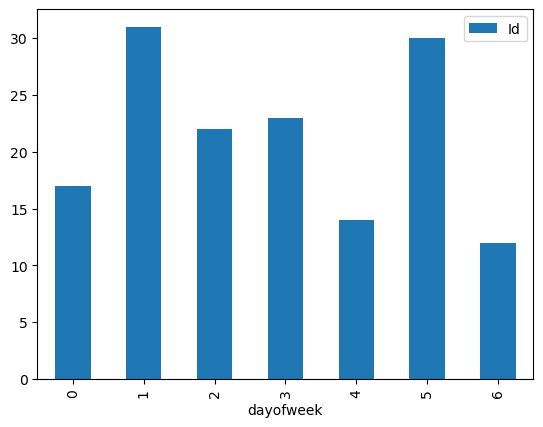

In [50]:
# Get max steps per week, find day of week
# Plot frequency of each day being the max to show which days are people most active

rm_zeros = daily_df.query("TotalSteps > 0") # remove rows where total steps are 0

max_steps_msk = rm_zeros.groupby(['Id','weeknum'])['TotalSteps'].transform('max') == rm_zeros['TotalSteps'] # Boolean mask that tells me which rows are the max steps for each user per week, I can use this to filter the df and find which day of the week that is - borrowed from [1]
max_steps = rm_zeros.loc[max_steps_msk, ['Id','dayofweek']] # Find day of the week for each max
    
max_count = max_steps.groupby(['dayofweek']).count() # Count frequency of each day
max_count.plot(kind='bar')

Activity as it becomes May (improving weather)

<Axes: xlabel='ActivityDate'>

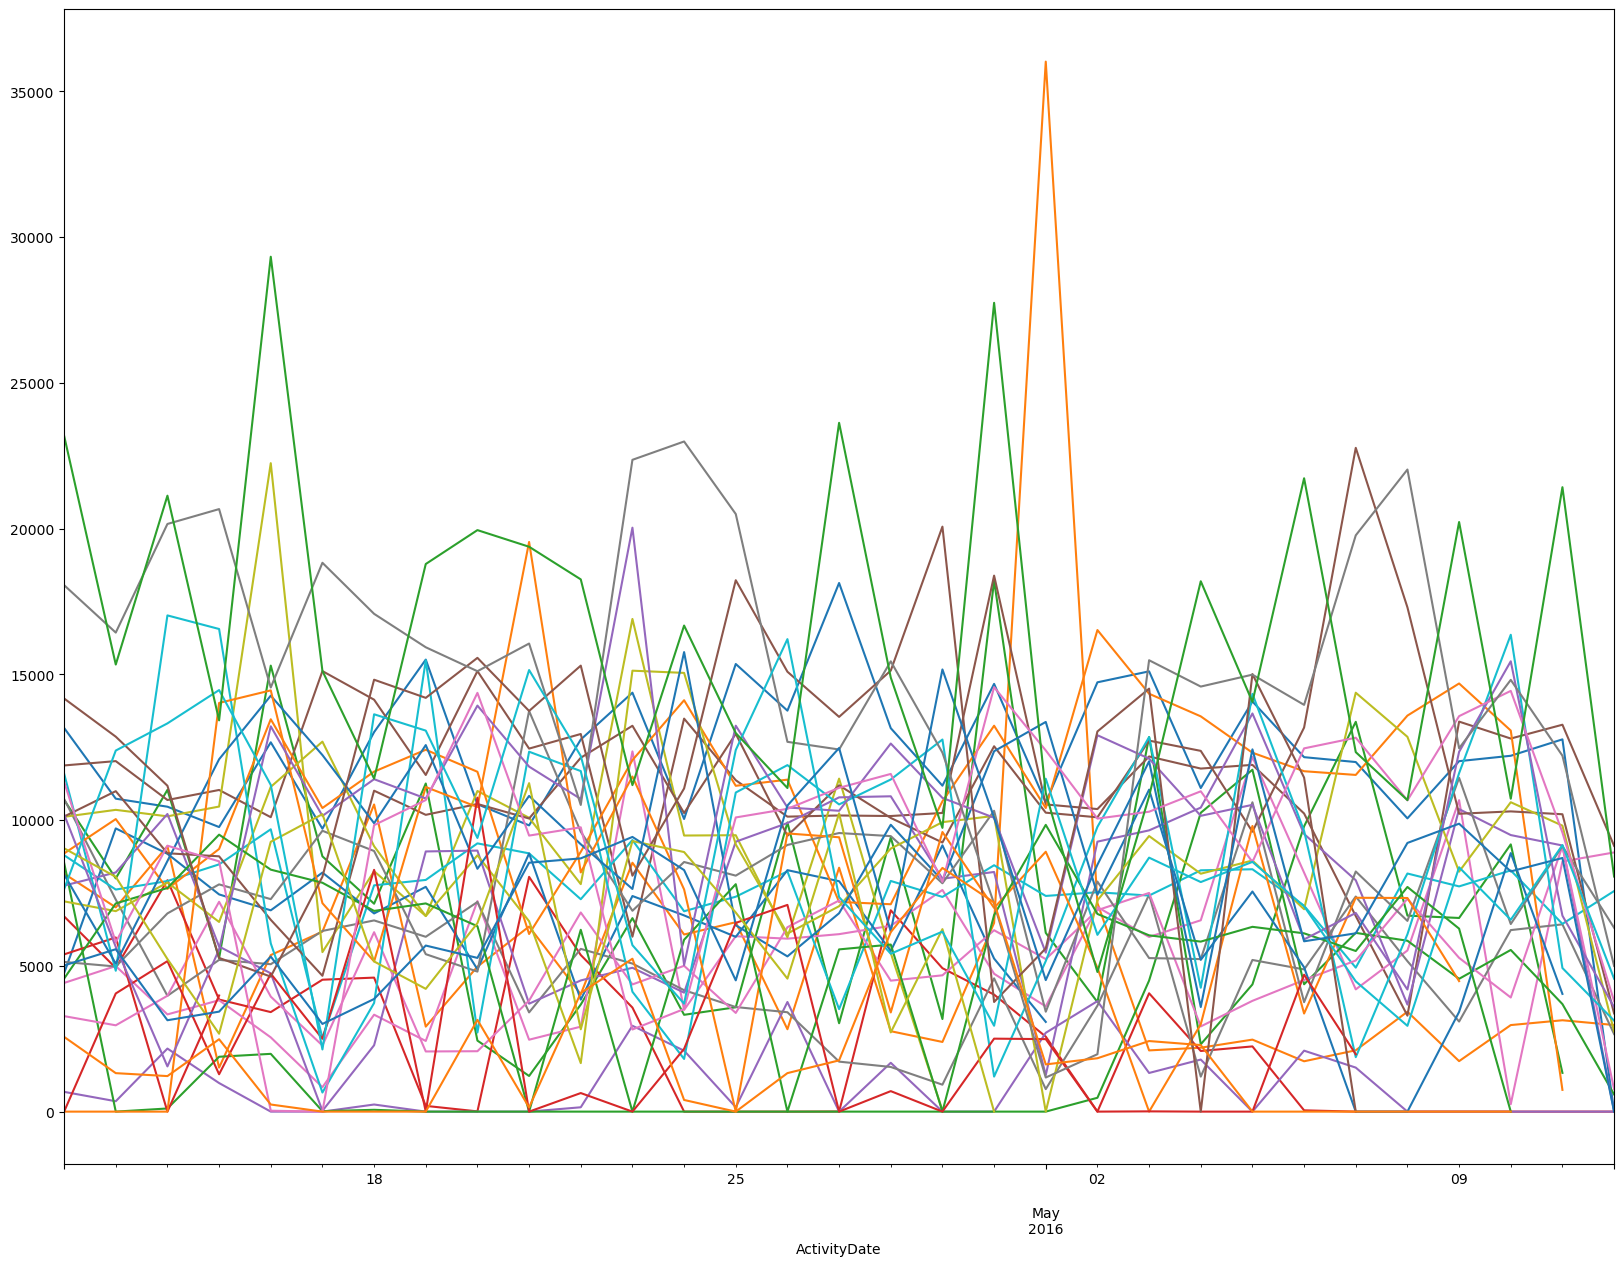

In [51]:
# Started with a quick overall plot to see if there was some sign of a general trend, there doesn't appear to be

timeline_df = daily_df.pivot(columns='Id', values='TotalSteps', index='ActivityDate')
timeline_df.plot(figsize=(20,15), legend=False)

In [52]:
pd.options.mode.chained_assignment = None # Suppress SettingWithCopyWarning

In [53]:
# Looking at the correlation between date and total steps, total distance and calories
# There is no significant correlation

corr_df = daily_df[['ActivityDate', 'TotalSteps', 'TotalDistance', 'Calories']]
corr_df['ActivityDate'] = pd.to_numeric(corr_df['ActivityDate'])
corr_df.corr().style.background_gradient(cmap="Blues")

,ActivityDate,TotalSteps,TotalDistance,Calories
ActivityDate,1.000000,-0.043931,-0.040169,-0.092843
TotalSteps,-0.043931,1.000000,0.985369,0.591568
TotalDistance,-0.040169,0.985369,1.000000,0.644962
Calories,-0.092843,0.591568,0.644962,1.000000


In [54]:
pd.options.mode.chained_assignment = 'warn' # Return to default

## Sleep Log Analysis

In [55]:
sleep_log.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,1,327,346
1,1503960366,2016-04-13,2,384,407
2,1503960366,2016-04-15,1,412,442
3,1503960366,2016-04-16,2,340,367
4,1503960366,2016-04-17,1,700,712


In [56]:
sleep_log['Id'].nunique()

24

Of the 33 people in the study, only 24 used their tracker to record their sleep at least once

In [57]:
# Count of users getting their recommended 8 hours of sleep on average

avg_sleep = sleep_log[['Id', 'TotalMinutesAsleep']].groupby('Id').mean()

sleep_8_hrs = pd.DataFrame(data={'User_Count': [len(avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480]), len(avg_sleep[avg_sleep['TotalMinutesAsleep'] >= 480])], 'MinAsleep': ['<480', '480+'], '%_Total_Users': [round((len(avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480])/sleep_users)*100), round((len(avg_sleep[avg_sleep['TotalMinutesAsleep'] >= 480])/sleep_users)*100)]})

sleep_8_hrs.set_index('MinAsleep')

,User_Count,%_Total_Users
MinAsleep,,
<480,22,92
480+,2,8


In [58]:
# Further breakdown of the users sleeping less than the recommended 8 hours on average

lt_8_hrs = avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480]
lt_8_hrs_cnt = pd.DataFrame(data=(lt_8_hrs['TotalMinutesAsleep'].value_counts(bins=3, sort=False)))

lt_8_hrs_cnt

,TotalMinutesAsleep
"(60.581, 200.259]",3
"(200.259, 339.519]",3
"(339.519, 478.778]",16


## Weight Log Analysis

In [59]:
weight_log.head()

,Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
0,1503960366,2016-05-02,52.599998,115.963147,22.650000,True,1462233599000
1,1503960366,2016-05-03,52.599998,115.963147,22.650000,True,1462319999000
2,1927972279,2016-04-13,133.500000,294.317120,47.540001,False,1460509732000
3,2873212765,2016-04-21,56.700001,125.002104,21.450001,True,1461283199000
4,2873212765,2016-05-12,57.299999,126.324875,21.690001,True,1463097599000


In [60]:
weight_log['Id'].nunique()

8

Of 33 people enrolled in this study, only 8 used their tracker to record their weight at least once.

In [61]:
# I am only interested in users that recorded their weight more than once, so I can observe any trends

weight_log['dups'] = weight_log['Id'].duplicated(keep=False) # Mark all dups as "True" so they can be kept

weight_log_trends = weight_log.query('dups == True') # Query to grab all dups

weight_log_trends['Id'].nunique()

6

Of those 8, only 6 recorded their weight at least twice. </br>
We know from the original examination that none of the users recorded their weight everyday.

In [62]:
# Pivot the df so that the dates are the index and Ids are the fields

weight_tl = weight_log_trends.pivot(columns='Id', values='WeightPounds', index='Date')

weight_tl

Id,1503960366,2873212765,4319703577,4558609924,6962181067,8877689391
Date,,,,,,
2016-04-12,NaN,NaN,NaN,NaN,137.788914,189.156628
2016-04-13,NaN,NaN,NaN,NaN,136.907061,187.172464
2016-04-14,NaN,NaN,NaN,NaN,136.025217,186.290612
2016-04-15,NaN,NaN,NaN,NaN,135.584291,NaN
2016-04-16,NaN,NaN,NaN,NaN,136.686603,188.495234
2016-04-17,NaN,NaN,159.614681,NaN,135.363832,NaN
2016-04-18,NaN,NaN,NaN,153.662190,134.922906,189.156628
2016-04-19,NaN,NaN,NaN,NaN,135.363832,188.054316
2016-04-20,NaN,NaN,NaN,NaN,136.025217,187.172464


<Axes: xlabel='Date'>

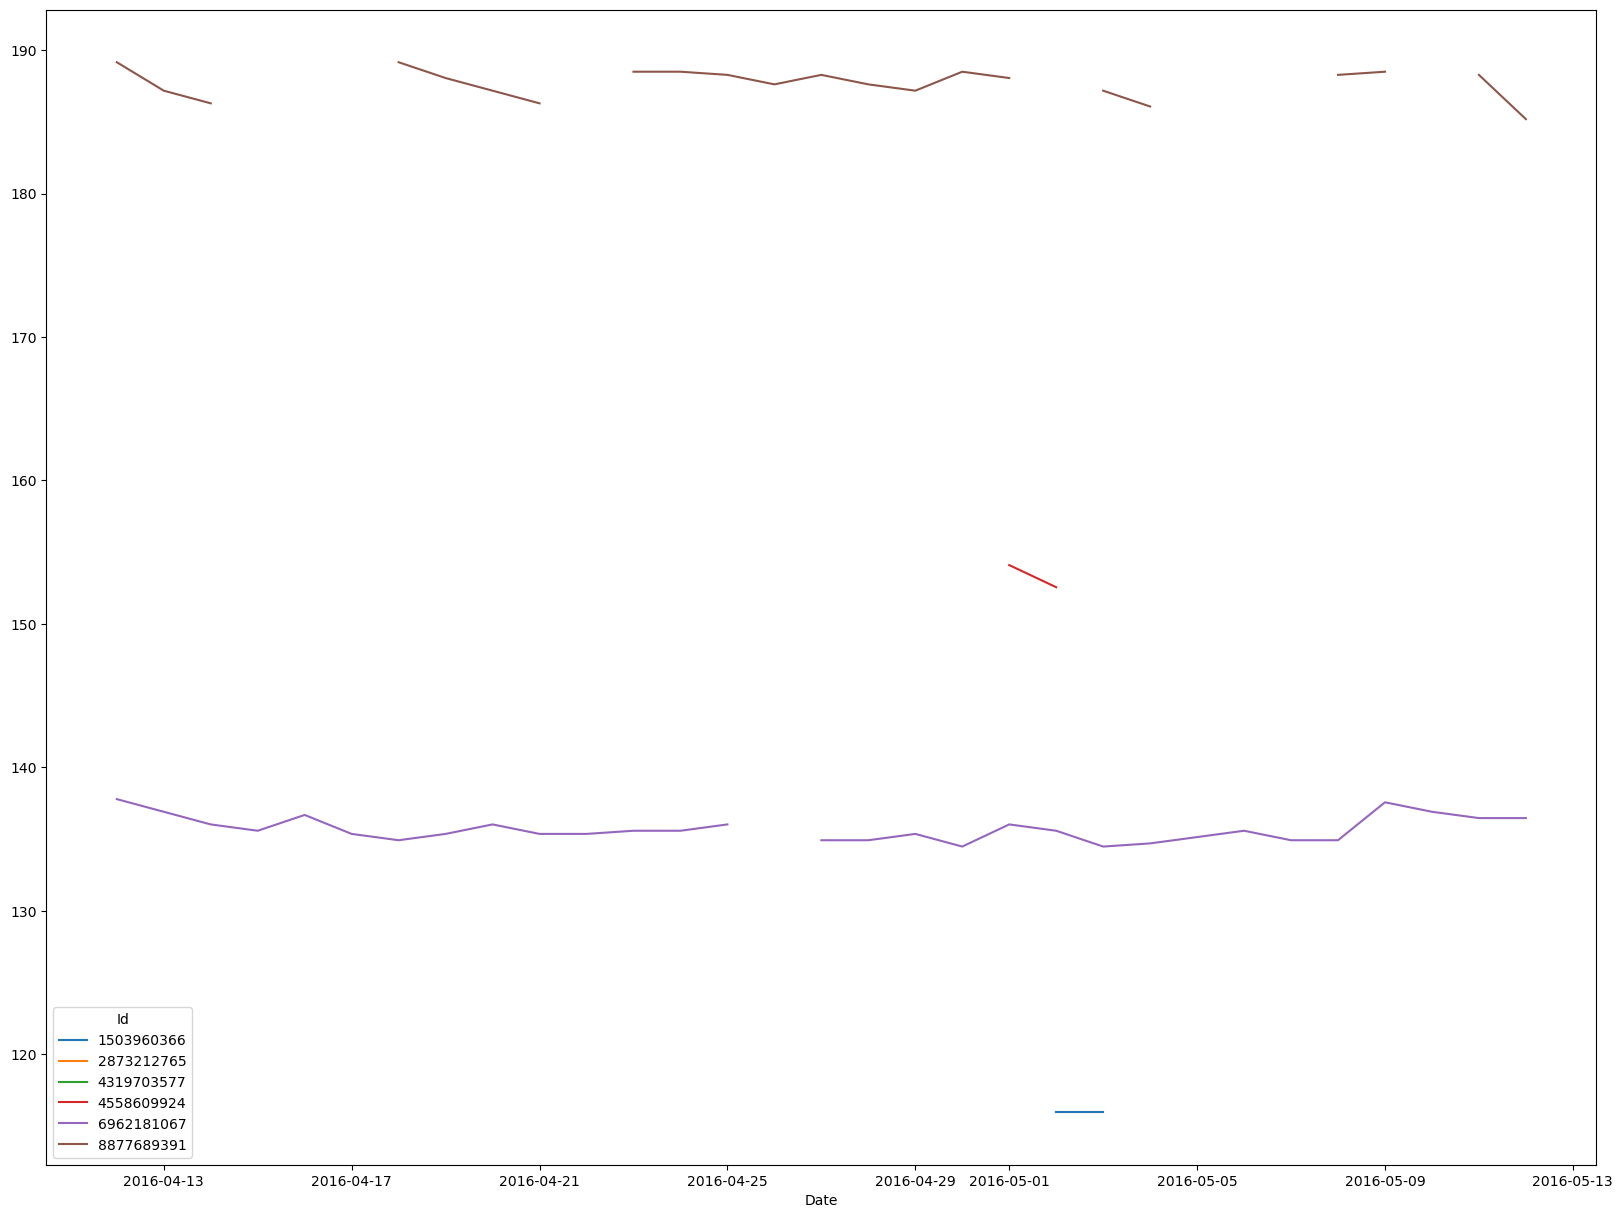

In [63]:
# Plot weight over the dates
# Non-consecutive weights won't appear in the graph

weight_tl.plot(figsize=(20,15))

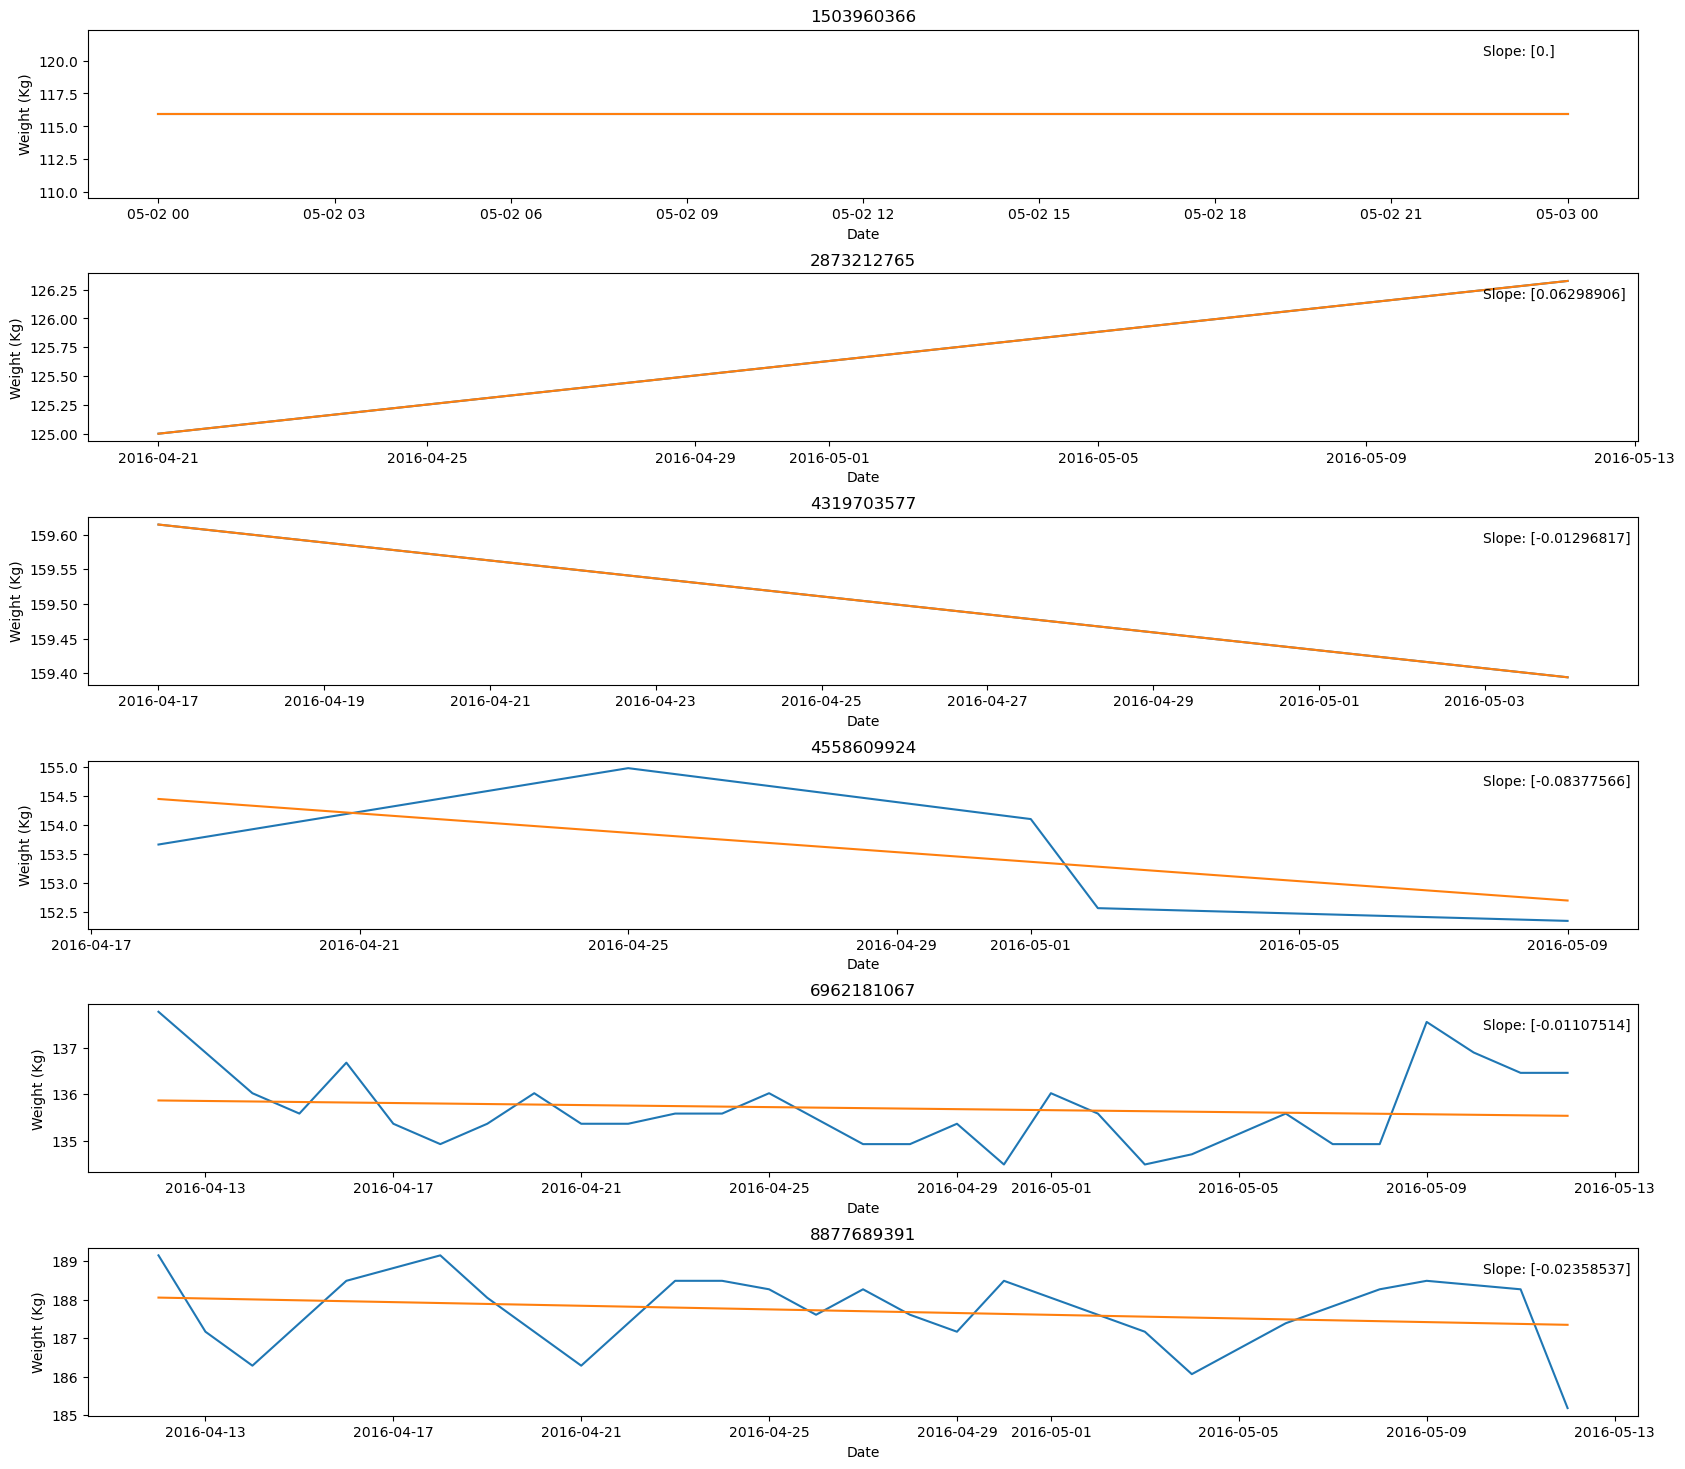

In [64]:
# I want to visualize (and quantify) the weight change of users and look for a relationship between weight and exercise
# I will do this with LinearRegression

weight_tl['time'] = np.arange(len(weight_tl.index)) # Add time field

weight_change = pd.DataFrame() # Create new df for storing the slope, weight change, number of days between first weight and last weight, average steps, and average calories
weight_change.index = ['trendline slope', 'weight diff (Kg)', 'date diff', 'avg steps', 'avg calories']

fig, axes = plt.subplots(6,1) # Set up subplots for each user
plt.subplots_adjust(hspace=0.45)

a = 0 # variable for the axes of each graph

for i in range(0,6):
    weight_tl_ = weight_tl.loc[:,[weight_tl.columns.values[i],'time']].dropna() # remove NAs for the current column

    X = weight_tl_.loc[:,['time']] 
    y = weight_tl_.loc[:,weight_tl.columns.values[i]]

    model = LinearRegression()
    model.fit(X,y)

    y_pred = pd.Series(model.predict(X), index=X.index)

    ax = y.plot(figsize=(20,18), ylabel="Weight (Kg)", title=weight_tl.columns.values[i], ax=axes[a]) # Plot current column values 
    ax = y_pred.plot(ax=ax, linewidth=1.5) # Plot trendline
    txt = "Slope: " + str(model.coef_) # Slope text
    plt.text(x=0.90,y=0.85,s=txt,transform=ax.transAxes) # Add the slopes to the graphs
    
    a += 1
    
    # Insert data into the new df created above
    weight_change[weight_tl.columns.values[i]] = [str(model.coef_), (weight_tl_.iloc[-1][weight_tl.columns.values[i]] - weight_tl_.iloc[0][weight_tl.columns.values[i]]), (weight_tl_.iloc[-1]['time'] - weight_tl_.iloc[0]['time']), round(avg_steps_cals['TotalSteps'].loc[avg_steps_cals.index == weight_tl.columns.values[i]].values[0]), round(avg_steps_cals['Calories'].loc[avg_steps_cals.index == weight_tl.columns.values[i]].values[0])]

In [65]:
weight_change

,1503960366,2873212765,4319703577,4558609924,6962181067,8877689391
trendline slope,[0.],[0.06298906],[-0.01296817],[-0.08377566],[-0.01107514],[-0.02358537]
weight diff (Kg),0.0,1.32277,-0.220459,-1.32277,-1.32277,-3.968327
date diff,1.0,21.0,17.0,21.0,30.0,30.0
avg steps,12117,7556,7269,7685,9795,16040
avg calories,1816,1917,2038,2033,1982,3420


# Supplemental Study Data

*Insert brief description why I wanted supplementary data and introduce the study*

Overall, activity trackers mainly motivated users to
monitor activity patterns (35.9%, n = 85), improve fitness
(27.4%, n = 65) and improve health (18.1%, n = 43)

The majority
of current users either strongly or somewhat agreed that
various features on their trackers were useful, including:
steps (95%), active minutes (76%), sleep (66%), heart rate
(63%), stairs climbed (58%), energy burned (57%). 

Fewer
agreed that the food intake feature was useful (36%).

The majority of current (89%) and former
(54%) users agreed that the real time monitoring was
useful, while slightly fewer current users (78%) and
former users (41%) agreed that long term monitoring
was useful.

The majority of current
(81.4%) and former (51.3%) users believed that they in-
corporated more physical activity into their day whilst
wearing their activity tracker. In contrast, only 40.2% of
current users and 13.5% of former users reported they
had improved their eating patterns as a results of using
their tracker, and even fewer reported they had changed
their sleeping pattern (24.1% of current users and 10.8%
of former users). 

Overall, 68.3% of current users and 70.2% of
former users reported an initial increase in their activity
levels. However, 9.5% of current users and 27.0% of
former users reported that this increase was transient,
and that their activity levels had subsequently declined
to baseline levels.

The majority of participants reported that they
did not use social features (65%) nor did they share their
activity data on social media platforms (77%). Amongst
those who did report using social features, the most
common platform for this was the trackers’ support soft-
ware (35%), and relatively few users reported sharing
their data to external social networking sites such as
Strava, Facebook or Instagram (1–5%). The prime motiv-
ation for using social features was reportedly “to compete with friends” (17%).

Table 3

Table 4

current users were more likely to be in a
relationship than former users.

 Overall, users were most likely to obtain
their activity trackers by purchasing it themselves
(56.58%) or receiving it as a gift from their family
(43.5%).

# Summary of Analysis and Recommendations

*Insert key findings here* \
Also consider preparing a slide or PDF with recommendations and supporting evidence to act as a deliverable

# Sources

https://www.kaggle.com/datasets/arashnic/fitbit

https://stackoverflow.com/questions/71311300/find-max-of-a-group-and-return-another-columns-value